In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
from torch import nn
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import confusion_matrix
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
from loss import FocalLoss

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-v1.1")

# Transformations
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class CustomDataset(Dataset):
  def __init__(self, image_paths, labels, text_inputs, tokenizer, transform = None, file_path ='/scratch/pyc298/data'): #make sure to update the file_path
    self.image_paths = image_paths
    self.labels = labels 
    self.text_inputs = text_inputs
    self.transform = transform
    self.file_path = file_path
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    #Get the image 
    image_path = self.image_paths[idx]

    #Generate the Full Path
    full_path = os.path.join(self.file_path, image_path)
    #Open Image from Path
    image = Image.open(full_path).convert('L')  # Grayscale
    #Transform
    if self.transform:
            image = self.transform(image)

    text = self.text_inputs[idx]
    #add encoder and vocab things
    encoded_dict = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=250,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

    # Extract tensors
    input_ids = encoded_dict['input_ids'].squeeze(0)
    attention_mask = encoded_dict['attention_mask'].squeeze(0)

    return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(self.labels[idx], dtype=torch.long) #convert to tensor of long
        }

In [3]:
import numpy as np
import pandas as pd
np.random.seed(2024)
torch.manual_seed(2024)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2024)

#make this a config
path_to_dir = "/scratch/pyc298/code"
csv_name = "final_cxr_free_text.csv"

dataset = pd.read_csv(os.path.join(path_to_dir, csv_name ))

# Split the dataset
train_data, test_data = train_test_split(dataset, test_size=0.40, random_state=42)
valid_data, test_data = train_test_split(test_data, test_size = 0.50, random_state = 42)
train_data.reset_index(drop = True, inplace = True)
valid_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)



In [4]:
print(train_data["is_pneumonia"].value_counts(),
test_data["is_pneumonia"].value_counts(),
valid_data["is_pneumonia"].value_counts())

is_pneumonia
0    13059
1     1408
Name: count, dtype: int64 is_pneumonia
0    4391
1     432
Name: count, dtype: int64 is_pneumonia
0    4340
1     483
Name: count, dtype: int64


In [5]:
train_dataset = CustomDataset(image_paths = train_data["image_path"], labels = train_data["is_pneumonia"], text_inputs = train_data["free_text"], tokenizer = tokenizer, transform = transformations)
test_dataset = CustomDataset(image_paths = test_data["image_path"], labels = test_data["is_pneumonia"], text_inputs = test_data["free_text"], tokenizer = tokenizer, transform = transformations)
valid_dataset = CustomDataset(image_paths = valid_data["image_path"], labels = valid_data["is_pneumonia"], text_inputs = valid_data["free_text"], tokenizer = tokenizer, transform = transformations)
batch_size = 64
print(len(train_dataset), len(valid_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

14467 4823 4823


In [7]:
import torch
from torch import nn
import torchmetrics
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt


class BaseModel(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4, loss_function=nn.BCEWithLogitsLoss()):
        super().__init__()
        self.save_hyperparameters()

        # Loss function
        self.loss_function = loss_function

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task='binary')
        self.val_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task='binary')
        self.test_accuracy = torchmetrics.Accuracy(num_classes=num_classes, task='binary')
        self.precision = torchmetrics.Precision(num_classes=num_classes, task='binary')
        self.recall = torchmetrics.Recall(num_classes=num_classes, task='binary')
        self.f1_score = torchmetrics.F1Score(num_classes=num_classes, task='binary')
        self.auroc = torchmetrics.AUROC(num_classes=num_classes, task='binary')
        self.confmat = torchmetrics.ConfusionMatrix(num_classes=num_classes, task='binary')

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        targets = batch['labels'].unsqueeze(1).float()
        outputs = self(batch['image'], batch['input_ids'], batch['attention_mask'])
        loss = self.loss_function(outputs, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', self.train_accuracy(outputs,targets), on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        targets = batch['labels'].unsqueeze(1).float()
        outputs = self(batch['image'], batch['input_ids'], batch['attention_mask'])
        loss = self.loss_function(outputs, targets)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', self.val_accuracy(outputs, targets), on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        targets = batch['labels'].unsqueeze(1).float()
        outputs = self(batch['image'], batch['input_ids'], batch['attention_mask'])
        loss = self.loss_function(outputs, targets)
        preds = torch.sigmoid(outputs).round()

        self.confmat.update(preds, targets)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_accuracy(outputs, targets),on_epoch=True, prog_bar=True)
        self.log('precision', self.precision(outputs, targets),on_epoch=True )
        self.log('recall', self.recall(outputs, targets),on_epoch=True)
        self.log('f1_score', self.f1_score(outputs, targets),on_epoch=True)
        self.log('auroc', self.auroc(outputs, targets),on_epoch=True)

    def log_confusion_matrix(self, cm):
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title('Confusion Matrix')
        plt.close(fig)
        
        # Log to TensorBoard
        self.logger.experiment.add_figure("Confusion Matrix", fig, self.current_epoch)

    def on_test_epoch_end(self):
        cm = self.confmat.compute().cpu().numpy()
        self.log_confusion_matrix(cm)
        
    def set_parameter_requires_grad(self, freeze_it):
      # Freeze layers up to the specified block
      layers_to_freeze = {
          'conv1': self.image_encoder.conv1,
          'layer1': self.image_encoder.layer1,
          'layer2': self.image_encoder.layer2,
          'layer3': self.image_encoder.layer3
          # 'layer4': self.image_encoder.layer4
      }

      for name, layer in layers_to_freeze.items():
          if name in freeze_it:
              for param in layer.parameters():
                  param.requires_grad = False
          else:
              break  # Stop at the first unfrozen layer
  


In [8]:
from torchvision import models
from torchvision.models.resnet import ResNet50_Weights
from transformers import BertModel

class MultimodalModel(BaseModel):
    def __init__(self, num_classes, learning_rate=1e-4, loss_function=nn.BCEWithLogitsLoss()):
        super().__init__(num_classes, learning_rate, loss_function)

        # Image encoder setup
        self.image_encoder = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.image_encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.image_encoder.fc.in_features
        self.image_encoder.fc = nn.Linear(num_ftrs, 256)
        self.set_parameter_requires_grad(['conv1', 'layer1', 'layer2'])  # Freezes specified layers

        # Text encoder setup
        self.text_encoder = BertModel.from_pretrained('dmis-lab/biobert-v1.1')
        self.text_fc = nn.Linear(768, 256)

        # Combined output layer
        self.combine_fc = nn.Linear(512, num_classes)

    def forward(self, images, input_ids, attention_mask):
        image_features = self.image_encoder(images)
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.text_fc(text_outputs.pooler_output)
        combined_features = torch.cat((image_features, text_features), dim=1)
        return self.combine_fc(combined_features)




In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Callback
from pytorch_lightning.loggers import TensorBoardLogger
train_steps_per_epoch = len(train_dataset) // batch_size + (len(train_dataset) % batch_size > 0)


class ClearCacheCallback(Callback):
    def on_epoch_end(self, trainer, pl_module):
        torch.cuda.empty_cache()
        print("Cleared GPU cache")

logger = TensorBoardLogger('model_logs', name='focal_loss_Multimodal_Full')
# Callbacks
clear_cache_callback = ClearCacheCallback()

early_stop_callback = EarlyStopping(
    monitor='val_loss',    
    patience=3,          
    verbose=True,
    mode='min'            # 'min' or 'max' (whether the monitored quantity should decrease or increase)
)
trainer = pl.Trainer(logger=logger, 
                     log_every_n_steps=50,  # Log at the end of each epoch
                     callbacks=[early_stop_callback, clear_cache_callback],
                     max_epochs=15, 
                     devices=1, 
                     accelerator="gpu" if torch.cuda.is_available() else "cpu") # Automatically choose GPU if available

model = MultimodalModel(num_classes=1, loss_function = FocalLoss())
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders =valid_loader)
trainer.test(model, dataloaders=test_loader)

 # Checking bimodal sensitivity


In [ ]:
#Creating the skewed dataloader 

# Shuffle column 'image_path'
shuffled_image = test_data.copy()
shuffled_image['image_path'] = np.random.permutation(shuffled_image['image_path'])
shuffled_image_dataset = CustomDataset(image_paths = shuffled_image["image_path"], labels = shuffled_image["is_pneumonia"], text_inputs = shuffled_image["free_text"], tokenizer = tokenizer, transform = transformations)
shuffled_image_loader = DataLoader(shuffled_image_dataset, batch_size=batch_size, num_workers=2)



# Shuffle column 'image_path'
shuffled_text = test_data.copy()
shuffled_text['free_text'] = np.random.permutation(shuffled_text['free_text'])
shuffled_text_dataset = CustomDataset(image_paths = shuffled_text["image_path"], labels = shuffled_text["is_pneumonia"], text_inputs = shuffled_text["free_text"], tokenizer = tokenizer, transform = transformations)
shuffled_text_loader = DataLoader(shuffled_text_dataset, batch_size=batch_size, num_workers=2)



In [11]:
def bimodal_sensitivity(model, dataloader, cm_image_path, metrics_file_path, device):
    model.to(device)  # Move the model to the specified device
    model.eval()

    # Initialize metrics
    accuracy = torchmetrics.Accuracy(num_classes=1, task='binary').to(device)
    precision = torchmetrics.Precision(num_classes=1, task='binary').to(device)
    recall = torchmetrics.Recall(num_classes=1, task='binary').to(device)
    f1 = torchmetrics.F1Score(num_classes=1, task='binary').to(device)
    auroc = torchmetrics.AUROC(num_classes=1, task='binary').to(device)
    
    # Containers for true and predicted labels
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad(): 
        for batch in dataloader:
            # Move all inputs and targets to the specified device
            targets = batch['labels'].unsqueeze(1).float().to(device)
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Compute outputs
            outputs = model(image, input_ids, attention_mask)
            preds = torch.sigmoid(outputs).round()

            # Update metric
            accuracy.update(preds, targets)
            precision.update(preds, targets)
            recall.update(preds, targets)
            f1.update(preds, targets)
            auroc.update(preds, targets)

            # Collect labels for confusion matrix
            true_labels.extend(targets.cpu().tolist())
            predicted_labels.extend(preds.cpu().tolist())
        torch.cuda.empty_cache()


    # Compute metrics
    metrics = {
        "Accuracy": accuracy.compute().item(),
        "Precision": precision.compute().item(),
        "Recall": recall.compute().item(),
        "F1 Score": f1.compute().item(),
        "AUROC": auroc.compute().item()
    }
    
    # Output metrics to console
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    
    # Save metrics to a text file
    with open(metrics_file_path, "w") as file:
        for metric, value in metrics.items():
            file.write(f"{metric}: {value}\n")
    
    # Calculate and plot confusion matrix using seaborn
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    
    # Save the confusion matrix as an image
    plt.savefig(cm_image_path)
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
bimodal_sensitivity(model, shuffled_image_loader, "bimodal_sensitivity_tests/bce_loss_Multimodal_Full_shuffImageCM.jpg", "bimodal_sensitivity_tests/bce_loss_Multimodal_Full_shuffImageCM.txt", device )


In [ ]:
bimodal_sensitivity(model, shuffled_text_loader, "bimodal_sensitivity_tests/bce_loss_Multimodal_Full_shuffTextCM.jpg", "bimodal_sensitivity_tests/bce_loss_Multimodal_Full_shuffTextCM.txt", device )


# With 75 Subsampled

## Getting the dataset

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(2024)
torch.manual_seed(2024)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(2024)

#make this a config
path_to_dir = "/scratch/pyc298/code"
csv_name = "final_cxr_free_text75.csv"

dataset = pd.read_csv(os.path.join(path_to_dir, csv_name ))

# Split the dataset
train_data, test_data = train_test_split(dataset, test_size=0.40, random_state=42)
valid_data, test_data = train_test_split(test_data, test_size = 0.50, random_state = 42)
train_data.reset_index(drop = True, inplace = True)
valid_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print(train_data["is_pneumonia"].value_counts(),
test_data["is_pneumonia"].value_counts(),
valid_data["is_pneumonia"].value_counts())

train_dataset = CustomDataset(image_paths = train_data["image_path"], labels = train_data["is_pneumonia"], text_inputs = train_data["free_text"], tokenizer = tokenizer, transform = transformations)
test_dataset = CustomDataset(image_paths = test_data["image_path"], labels = test_data["is_pneumonia"], text_inputs = test_data["free_text"], tokenizer = tokenizer, transform = transformations)
valid_dataset = CustomDataset(image_paths = valid_data["image_path"], labels = valid_data["is_pneumonia"], text_inputs = valid_data["free_text"], tokenizer = tokenizer, transform = transformations)
batch_size = 64
print(len(train_dataset), len(valid_dataset), len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

## Training loop

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Callback
from pytorch_lightning.loggers import TensorBoardLogger
train_steps_per_epoch = len(train_dataset) // batch_size + (len(train_dataset) % batch_size > 0)


class ClearCacheCallback(Callback):
    def on_epoch_end(self, trainer, pl_module):
        torch.cuda.empty_cache()
        print("Cleared GPU cache")

logger = TensorBoardLogger('model_logs', name='focal_loss_Multimodal_75')
# Callbacks
clear_cache_callback = ClearCacheCallback()

early_stop_callback = EarlyStopping(
    monitor='val_loss',    
    patience=3,          
    verbose=True,
    mode='min'            # 'min' or 'max' (whether the monitored quantity should decrease or increase)
)
trainer = pl.Trainer(logger=logger, 
                     log_every_n_steps=50,  # Log at the end of each epoch
                     callbacks=[early_stop_callback, clear_cache_callback],
                     max_epochs=15, 
                     devices=1, 
                     accelerator="gpu" if torch.cuda.is_available() else "cpu") # Automatically choose GPU if available

model = MultimodalModel(num_classes=1, loss_function = nn.BCEWithLogitsLoss())
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders =valid_loader)
trainer.test(model, dataloaders=test_loader)

In [17]:
#Checking bimodal sensitivity 

#Creating the skewed dataloader 

# Shuffle column 'image_path'
shuffled_image = test_data.copy()
shuffled_image['image_path'] = np.random.permutation(shuffled_image['image_path'])
shuffled_image_dataset = CustomDataset(image_paths = shuffled_image["image_path"], labels = shuffled_image["is_pneumonia"], text_inputs = shuffled_image["free_text"], tokenizer = tokenizer, transform = transformations)
shuffled_image_loader = DataLoader(shuffled_image_dataset, batch_size=batch_size, num_workers=2)



# Shuffle column 'image_path'
shuffled_text = test_data.copy()
shuffled_text['free_text'] = np.random.permutation(shuffled_text['free_text'])
shuffled_text_dataset = CustomDataset(image_paths = shuffled_text["image_path"], labels = shuffled_text["is_pneumonia"], text_inputs = shuffled_text["free_text"], tokenizer = tokenizer, transform = transformations)
shuffled_text_loader = DataLoader(shuffled_text_dataset, batch_size=batch_size, num_workers=2)



# Bimodal Sensitivity Tests

Accuracy: 0.9811726808547974
Precision: 0.9917355179786682
Recall: 0.9393346309661865
F1 Score: 0.9648241400718689
AUROC: 0.9681836366653442


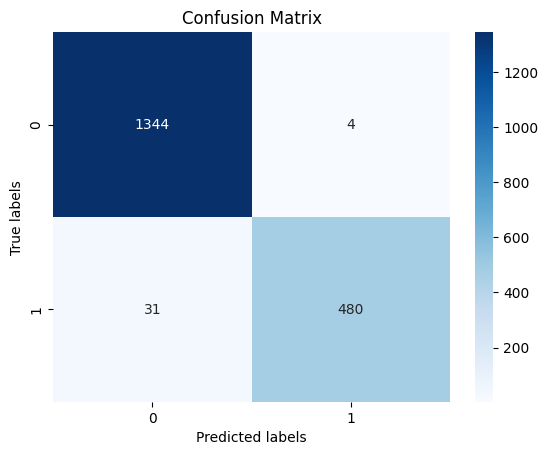

In [18]:
bimodal_sensitivity(model, shuffled_image_loader,
                    "bimodal_sensitivity_tests/focal_loss_Multimodal_75_shuffImageCM.jpg",
                    "bimodal_sensitivity_tests/focal_loss_Multimodal_75_shuffImageCM.txt", 
                    device )


Accuracy: 0.6110812425613403
Precision: 0.28099173307418823
Recall: 0.2661448121070862
F1 Score: 0.2733668386936188
AUROC: 0.5039922595024109


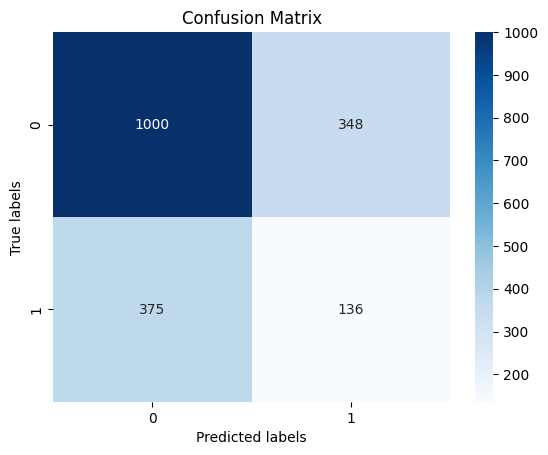

In [19]:
bimodal_sensitivity(model, shuffled_text_loader, 
                    "bimodal_sensitivity_tests/focal_loss_Multimodal_75_shuffTextCM.jpg", 
                    "bimodal_sensitivity_tests/focal_loss_Multimodal_75_shuffTextCM.txt", 
                    device )
